In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import sys
sys.path.append("../")

In [53]:
from sprintdl.main import *
from sprintdl.nets import *

In [3]:
device = torch.device('cuda',0)
from torch.nn import init
import torch
import math

# Define required

In [4]:
fpath = Path("/media/hdd/Datasets/ArtClass/")

tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]
bs = 256

# Actual process

In [5]:
il = ImageList.from_files(fpath, tfms=tfms)

In [6]:
il

ImageList (36702 items)
[PosixPath('/media/hdd/Datasets/ArtClass/Unpopular/mimang.art/69030963_140928767119437_3621699865915593113_n.jpg'), PosixPath('/media/hdd/Datasets/ArtClass/Unpopular/mimang.art/72464485_484151519164558_7996390942427275987_n.jpg'), PosixPath('/media/hdd/Datasets/ArtClass/Unpopular/mimang.art/67061598_659075951237852_8193482831220395614_n.jpg'), PosixPath('/media/hdd/Datasets/ArtClass/Unpopular/mimang.art/52369429_387255328723206_9033916457772710578_n.jpg'), PosixPath('/media/hdd/Datasets/ArtClass/Unpopular/mimang.art/67249582_2358754971005882_1419227919627445111_n.jpg'), PosixPath('/media/hdd/Datasets/ArtClass/Unpopular/mimang.art/53117277_787218161655836_7400982805295717482_n.jpg'), PosixPath('/media/hdd/Datasets/ArtClass/Unpopular/mimang.art/66306740_2081645612139014_2862011611265245646_n.jpg'), PosixPath('/media/hdd/Datasets/ArtClass/Unpopular/mimang.art/51053509_419271458822091_6368645951995838212_n.jpg'), PosixPath('/media/hdd/Datasets/ArtClass/Unpopular/mim

In [7]:
tm= Path("/media/hdd/Datasets/ArtClass/Unpopular/mimang.art/69030963_140928767119437_3621699865915593113_n.jpg")

In [8]:
str(tm).split("/")[-3]

'Unpopular'

In [9]:
sd = SplitData.split_by_func(il, partial(random_splitter, p_valid = .2))
ll = label_by_func(sd, lambda x: str(x).split("/")[-3], proc_y=CategoryProcessor())

In [10]:
n_classes = len(set(ll.train.y.items))

In [11]:
data = ll.to_databunch(bs, c_in=3, c_out=2)

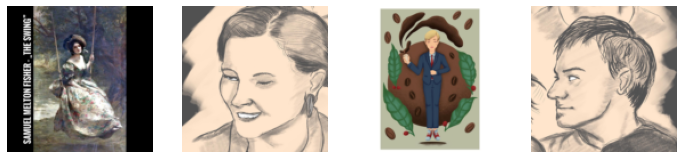

In [12]:
show_batch(data, 4)

In [13]:
lr = .001
pct_start = 0.5
phases = create_phases(pct_start)
sched_lr  = combine_scheds(phases, cos_1cycle_anneal(lr/10., lr, lr/1e5))
sched_mom = combine_scheds(phases, cos_1cycle_anneal(0.95, 0.85, 0.95))

cbfs = [
    partial(AvgStatsCallback,accuracy),
    partial(ParamScheduler, 'lr', sched_lr),
    partial(ParamScheduler, 'mom', sched_mom),
        partial(BatchTransformXCallback, norm_imagenette),
    ProgressCallback,
    Recorder,
#     MixUp,
       partial(CudaCallback, device)]

loss_func=LabelSmoothingCrossEntropy()
arch = partial(xresnet18, c_out=n_classes)

# opt_func = partial(sgd_mom_opt, wd=0.01)
opt_func = adam_opt(mom=0.9, mom_sqr=0.99, eps=1e-6, wd=1e-2)
# opt_func = lamb

# Training

In [14]:
clear_memory()

In [15]:
# learn = get_learner(nfs, data, lr, conv_layer, cb_funcs=cbfs)
learn = Learner(arch(), data, loss_func, lr=lr, cb_funcs=cbfs, opt_func=opt_func)

In [16]:
# model_summary(learn, data)

In [17]:
learn.fit(3)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.638609,0.657498,0.647482,0.651101,01:49
1,0.600756,0.701830,0.586719,0.714154,01:56
2,0.552777,0.746952,0.550869,0.745152,01:54


In [21]:
save_model(learn, "m1", fpath)

Saved at /media/hdd/Datasets/ArtClass/models/m1


PosixPath('/media/hdd/Datasets/ArtClass/models/m1')

In [68]:
temp = Path('/media/hdd/Datasets/ArtClass/Popular/artgerm/10004370_1657536534486515_1883801324_n.jpg')

get_class_pred(temp, learn ,ll, 128)

0


'Unpopular'

In [34]:
temp = Path('/home/eragon/Downloads/Telegram Desktop/IMG_1800.PNG')

In [57]:
get_class_pred(temp, learn ,ll,128)

'Unpopular'

In [51]:
temp = Path('/home/eragon/Downloads/Telegram Desktop/IMG_20210106_180731.jpg')

In [60]:
get_class_pred(temp, learn ,ll,128)

'Unpopular'

# Digging in

In [ ]:
show_batch

In [ ]:
learn.recorder.plot_lr()

In [ ]:
learn.recorder.plot_loss()

In [ ]:
dict_runner = {
    "xres18":[1, partial(xresnet18, c_out=n_classes), data, loss_func, cbfs, opt_func],
    "xres34":[1, partial(xresnet34, c_out=n_classes), data, loss_func, cbfs, opt_func],
    "xres50":[1, partial(xresnet50, c_out=n_classes), data, loss_func, cbfs, opt_func],
}

In [ ]:
multiple_